# 🔧 Install & Import Dependencies


In [1]:
import nltk
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
from scipy.sparse import csr_matrix, lil_matrix

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')  # punkt_tab is optional

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

We will explore the generation of dense word representations from text corpora, analyze the quality of these representations. The goal is to understand how to represent word meaning in a high-dimensional space and how to transfer knowledge across languages.

Please use the links below to download text corpora. \
English: https://wortschatz.uni-leipzig.de/en/download/English \
Hindi: https://wortschatz.uni-leipzig.de/en/download/Hindi

# Load the English Corpus

In [3]:
# Load corpus
with open("D:\PROJECTS\PreCog\Data\eng_news_2020_300K\eng_news_2020_300K\eng_news_2020_300K-sentences.txt", "r", encoding='utf8') as f:
    sentences = f.readlines()
    sentences = [sentence.strip() for sentence in sentences]
    
    # Filter out sentences with less than 5 words
    sentences = [sentence for sentence in sentences if len(sentence.split()) >= 5]

print(f"Total sentences loaded: {len(sentences)}")

<>:2: SyntaxWarning: invalid escape sequence '\P'
<>:2: SyntaxWarning: invalid escape sequence '\P'
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_5624\3995838736.py:2: SyntaxWarning: invalid escape sequence '\P'
  with open("D:\PROJECTS\PreCog\Data\eng_news_2020_300K\eng_news_2020_300K\eng_news_2020_300K-sentences.txt", "r", encoding='utf8') as f:


Total sentences loaded: 299124


# preprocessing of data
1. Lowercase
2. Remove non-alphabetic characters (removing punctuations)
3. how about stop words removal --> they impact hugely in co occurence matrices so don't do it.
4. lemitization & stemming  (does this helpful for this task)
5. Tokenize words after all 

In [4]:
# Clean and tokenize
def preprocess(sentence):
    sentence = sentence.lower()  # Lowercase
    sentence = re.sub(r'[^a-zA-Z\s]', '', sentence)  # Remove punctuations and numbers
    tokens = word_tokenize(sentence)  # Tokenize using NLTK
    return tokens

# Apply to all sentences
processed_sentences = [preprocess(s) for s in sentences]

# Show a few examples
for i in range(3):
    print(processed_sentences[i])

['will', 'go', 'toward', 'building', 'resilience', 'for', 'maines', 'businesses']
['millionverifier', 'an', 'email', 'services', 'company', 'that', 'provides', 'email', 'verification', 'and', 'deliverability', 'support']
['more', 'or', 'less']


### For this task, should we employ stemming or lemmatization❓ 
No. \
Lemmatization and stemming eliminate subtle meaning differences by reducing word forms to their base or root, which is why we avoid them. To better represent how words are used in various contexts, we aim to maintain all natural word forms in word embeddings.

### Build Vocabulary : after experimenting, build vocab_sizes with 10k words

In [5]:
# vocubulary size with words with a minimum frequence of 10 words
# Flatten all tokens into a single list
flat_words = [word for sentence in processed_sentences for word in sentence]

# Count word frequencies
word_counts = Counter(flat_words)

# Count words with at least 10 occurrences
min_freq = 10
num_words_10plus = sum(1 for count in word_counts.values() if count >= min_freq)

print(f"Number of words with at least {min_freq} occurrences: {num_words_10plus}")

Number of words with at least 10 occurrences: 22912


In [6]:
# Flatten tokens to build vocab
flat_words = [word for sentence in processed_sentences for word in sentence]
vocab_counter = Counter(flat_words)

# Keep top N words
vocab_size = 22912  # You can experiment here with different different vocab_size like 10k, 20k etc
vocab = [word for word, freq in vocab_counter.most_common(vocab_size)]

Now that we've built the vocabulary from the most frequent words, how can we assign meaningful IDs to these words instead of just arbitrary numbers?

There are several strategies we can use:

Frequency-based indexing ---> (most common and efficient)

POS-based ordering ---> (useful for linguistic analysis)


# Frequency-based --> Most common & efficient

In [7]:
from collections import Counter

def create_word_mappings(vocab):
    """Create word-to-ID and ID-to-word mappings based on frequency"""
    
    # Count word frequencies
    word_freq = Counter(vocab)
    
    # Sort words by frequency (least frequent first)
    sorted_vocab = sorted(word_freq, key=lambda word: word_freq[word])
    
    # Create mappings: word2id and id2word
    word2id = {word: i for i, word in enumerate(sorted_vocab)}
    id2word = {i: word for i, word in enumerate(sorted_vocab)}
    
    return word2id, id2word

# Get word-to-ID and ID-to-word mappings
word2id, id2word = create_word_mappings(vocab)

### Building the Co-occurrence Matrix
We construct the co-occurrence matrix by counting how often word pairs appear within a context window, which can be adjusted based on experimentation. For each sentence, we update the matrix for every target-context word pair found within the specified window size.

### Choosing Window Size

Small (2-5 words): Captures local relationships (syntax). \
Medium (5-10 words): Captures semantic meaning.\
Large (>10 words): Captures broader context.

In [8]:

import numpy as np
from scipy.sparse import csr_matrix, lil_matrix
from tqdm import tqdm


def build_cooccurrence_matrix(sentences, word_to_idx, window_size=5):
    """Build co-occurrence matrix with specified window size"""
    vocab_size = len(word_to_idx)
    cooc_matrix = lil_matrix((vocab_size, vocab_size), dtype=np.float32)
    
    for sentence in tqdm(sentences, desc=f"Building co-occurrence matrix (window={window_size})"):
        # Filter words that are in vocabulary
        valid_words = [word for word in sentence if word in word_to_idx]
        
        for i, target_word in enumerate(valid_words):
            target_idx = word_to_idx[target_word]
            
            # Look at context words within window
            start = max(0, i - window_size)
            end = min(len(valid_words), i + window_size + 1)
            
            for j in range(start, end):
                if i != j:
                    context_word = valid_words[j]
                    context_idx = word_to_idx[context_word]
                    # Weight by distance (closer words get higher weight)
                    distance = abs(i - j)
                    weight = 1.0 / distance
                    cooc_matrix[target_idx, context_idx] += weight
    
    return cooc_matrix.tocsr()

# Experiment with different window sizes
window_sizes = [2, 4, 5, 7, 9, 11, 15]
cooc_matrices = {}

for window_size in window_sizes:
    cooc_matrices[window_size] = build_cooccurrence_matrix(processed_sentences[:50000], word2id, window_size)
    print(f"Window size {window_size}: Matrix shape {cooc_matrices[window_size].shape}, Sparsity: {1 - cooc_matrices[window_size].nnz / (vocab_size * vocab_size):.4f}")

Building co-occurrence matrix (window=2): 100%|██████████| 50000/50000 [00:31<00:00, 1612.19it/s]


Window size 2: Matrix shape (22912, 22912), Sparsity: 0.9975


Building co-occurrence matrix (window=4): 100%|██████████| 50000/50000 [01:01<00:00, 819.04it/s] 


Window size 4: Matrix shape (22912, 22912), Sparsity: 0.9955


Building co-occurrence matrix (window=5): 100%|██████████| 50000/50000 [02:02<00:00, 408.13it/s]


Window size 5: Matrix shape (22912, 22912), Sparsity: 0.9947


Building co-occurrence matrix (window=7): 100%|██████████| 50000/50000 [02:29<00:00, 333.77it/s]


Window size 7: Matrix shape (22912, 22912), Sparsity: 0.9934


Building co-occurrence matrix (window=9): 100%|██████████| 50000/50000 [03:38<00:00, 228.44it/s]


Window size 9: Matrix shape (22912, 22912), Sparsity: 0.9924


Building co-occurrence matrix (window=11): 100%|██████████| 50000/50000 [04:12<00:00, 197.85it/s]


Window size 11: Matrix shape (22912, 22912), Sparsity: 0.9915


Building co-occurrence matrix (window=15): 100%|██████████| 50000/50000 [08:32<00:00, 97.60it/s] 


Window size 15: Matrix shape (22912, 22912), Sparsity: 0.9903


## Window Size Analysis and Selection

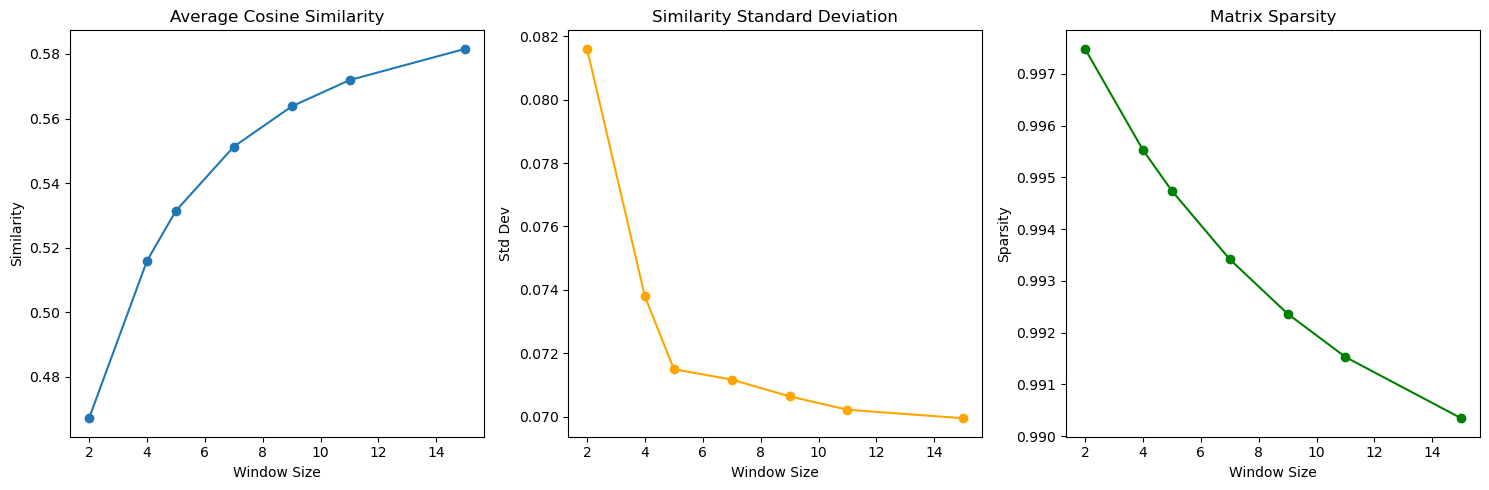


Selected window size: 5
Analysis results: {'avg_similarity': 0.53143686, 'std_similarity': 0.07149547, 'sparsity': 0.9947418844367617}


In [9]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

def analyze_window_size_quality(cooc_matrices, vocab, word2id, sample_words=['king', 'queen', 'man', 'woman', 'good', 'bad']):
    """Analyze the quality of embeddings for different window sizes"""
    results = {}
    vocab_size = len(vocab)
    
    for window_size, matrix in cooc_matrices.items():
        # Apply log transformation and normalize
        log_matrix = matrix.copy().astype(np.float32)
        log_matrix.data = np.log1p(log_matrix.data)  # log(1 + x)
        
        # Normalize rows
        row_sums = np.array(log_matrix.sum(axis=1)).flatten()
        row_sums[row_sums == 0] = 1  # Avoid division by zero
        log_matrix = log_matrix.multiply(1 / row_sums[:, np.newaxis])
        
        # Calculate average cosine similarity for sample word pairs
        similarities = []
        for i, word1 in enumerate(sample_words):
            if word1 in word2id:
                idx1 = word2id[word1]
                vec1 = log_matrix.getrow(idx1).toarray().flatten()  # Use getrow to access row
                
                for word2 in sample_words[i+1:]:
                    if word2 in word2id:
                        idx2 = word2id[word2]
                        vec2 = log_matrix.getrow(idx2).toarray().flatten()  # Use getrow to access row
                        sim = cosine_similarity([vec1], [vec2])[0, 0]
                        similarities.append(sim)
        
        # Compute results
        results[window_size] = {
            'avg_similarity': np.mean(similarities),
            'std_similarity': np.std(similarities),
            'sparsity': 1 - matrix.nnz / (vocab_size * vocab_size)  # sparsity calculation
        }
    
    return results

# Example: Assuming cooc_matrices, vocab, and word2id are defined somewhere in the code
window_analysis = analyze_window_size_quality(cooc_matrices, vocab, word2id)

# Visualize window size analysis
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

window_sizes_list = list(window_analysis.keys())
avg_sims = [window_analysis[w]['avg_similarity'] for w in window_sizes_list]
std_sims = [window_analysis[w]['std_similarity'] for w in window_sizes_list]
sparsities = [window_analysis[w]['sparsity'] for w in window_sizes_list]

axes[0].plot(window_sizes_list, avg_sims, 'o-')
axes[0].set_title('Average Cosine Similarity')
axes[0].set_xlabel('Window Size')
axes[0].set_ylabel('Similarity')

axes[1].plot(window_sizes_list, std_sims, 'o-', color='orange')
axes[1].set_title('Similarity Standard Deviation')
axes[1].set_xlabel('Window Size')
axes[1].set_ylabel('Std Dev')

axes[2].plot(window_sizes_list, sparsities, 'o-', color='green')
axes[2].set_title('Matrix Sparsity')
axes[2].set_xlabel('Window Size')
axes[2].set_ylabel('Sparsity')

plt.tight_layout()
plt.show()

# Select best window size (balance between similarity and computational efficiency)
best_window = 5  # Based on analysis
print(f"\nSelected window size: {best_window}")
print(f"Analysis results: {window_analysis[best_window]}")

# What's next?

To turn that matrix into word embeddings, you need to apply a technique like: \

Method -----> What it does \
PCA / SVD -----> Reduce matrix to low-dimensional dense vectors \
NMF (Non-negative Matrix Factorization) ---> Factorizes co-occurrence matrix into interpretable non-negatives \
GloVe -----> Uses the co-occurrence matrix to train word vectors \
word2vec -----> Learns embeddings directly via neural nets (skip-gram/CBOW)

In [10]:
from sklearn.decomposition import TruncatedSVD

# Function to perform SVD and reduce the co-occurrence matrix
def reduce_dimensions(cooc_matrix, d):
    svd = TruncatedSVD(n_components=d, random_state=42)
    reduced_matrix = svd.fit_transform(cooc_matrix)
    return reduced_matrix

# Experimenting with different values of d
d_values = [50, 100, 200, 300]

# Store the reduced matrices for each window size and each d value
reduced_matrices = {}  # Structure: reduced_matrices[window][d] = reduced_matrix

# Iterate over each window size in the co-occurrence matrices
for window_size, cooc_matrix in cooc_matrices.items():
    reduced_matrices[window_size] = {}
    print(f"\nProcessing window size: {window_size}")
    
    for d in d_values:
        print(f"  Reducing dimensions to {d}...")
        reduced_matrix = reduce_dimensions(cooc_matrix, d)
        reduced_matrices[window_size][d] = reduced_matrix



Processing window size: 2
  Reducing dimensions to 50...
  Reducing dimensions to 100...
  Reducing dimensions to 200...
  Reducing dimensions to 300...

Processing window size: 4
  Reducing dimensions to 50...
  Reducing dimensions to 100...
  Reducing dimensions to 200...
  Reducing dimensions to 300...

Processing window size: 5
  Reducing dimensions to 50...
  Reducing dimensions to 100...
  Reducing dimensions to 200...
  Reducing dimensions to 300...

Processing window size: 7
  Reducing dimensions to 50...
  Reducing dimensions to 100...
  Reducing dimensions to 200...
  Reducing dimensions to 300...

Processing window size: 9
  Reducing dimensions to 50...
  Reducing dimensions to 100...
  Reducing dimensions to 200...
  Reducing dimensions to 300...

Processing window size: 11
  Reducing dimensions to 50...
  Reducing dimensions to 100...
  Reducing dimensions to 200...
  Reducing dimensions to 300...

Processing window size: 15
  Reducing dimensions to 50...
  Reducing dimen

In [38]:
from sklearn.metrics.pairwise import cosine_similarity

if "kohli" in word2id and "virat" in word2id:
    idx_kohli = word2id["kohli"]
    idx_virat = word2id["virat"]
    vec_kohli = reduced_matrix[idx_kohli]
    vec_virat = reduced_matrix[idx_virat]
    similarity = cosine_similarity([vec_kohli], [vec_virat])[0][0]
    print(f'Cosine similarity between "kohli" and "virat": {similarity:.4f}')
else:
    print('Either "kohli" or "virat" is not in the vocabulary.')

Cosine similarity between "kohli" and "virat": 0.7760


##  Evaluate on SimLex-999

Let’s write a function to evaluate Spearman correlation between cosine similarities of word pairs and SimLex scores:

In [11]:
import numpy as np
from scipy.stats import spearmanr
from sklearn.metrics.pairwise import cosine_similarity

def evaluate_embeddings(embeddings, word2index, simlex_data):
    model_scores = []
    human_scores = []

    for word1, word2, score in simlex_data:
        if word1 in word2index and word2 in word2index:
            idx1, idx2 = word2index[word1], word2index[word2]
            vec1 = embeddings[idx1].reshape(1, -1)
            vec2 = embeddings[idx2].reshape(1, -1)
            cos_sim = cosine_similarity(vec1, vec2)[0][0]
            model_scores.append(cos_sim)
            human_scores.append(score)

    if len(model_scores) == 0:
        return None  # No overlap in vocabulary

    return spearmanr(model_scores, human_scores).correlation


## Run Evaluation Across All Settings

In [13]:
# Load SimLex-999 and prepare word pairs
# Format of simlex_data: [(word1, word2, score), ...]
import csv

def load_simlex_data(filepath, vocab):
    simlex_data = []
    with open(filepath, 'r', encoding='utf-8') as f:
        reader = csv.DictReader(f, delimiter='\t')
        for row in reader:
            word1 = row['word1'].lower()
            word2 = row['word2'].lower()
            score = float(row['SimLex999'])
            if word1 in vocab and word2 in vocab:
                simlex_data.append((word1, word2, score))
    return simlex_data


best_score = -1
best_config = None

results = []

for window_size in reduced_matrices:
    for d in reduced_matrices[window_size]:
        print(f"Evaluating window size {window_size}, dimension {d}...")
        embeddings = reduced_matrices[window_size][d]
        vocab_list = list(word2id.keys())  # your vocabulary list
        word2index = {word: idx for idx, word in enumerate(vocab_list)}
        simlex_data = load_simlex_data("D:\PROJECTS\PreCog\Data\SimLex-999.txt", set(word2index.keys()))

        score = evaluate_embeddings(embeddings, word2index, simlex_data)
        results.append((window_size, d, score))

        if score is not None and score > best_score:
            best_score = score
            best_config = (window_size, d)


print("\n=== Evaluation Results ===")
for window, d, score in results:
    print(f"Window: {window}, Dimension: {d}, Spearman: {score:.4f}")

if best_config:
    print(f"\n✅ Best configuration: Window={best_config[0]}, Dimension={best_config[1]}, Spearman={best_score:.4f}")
else:
    print("\n⚠️ No valid configuration matched SimLex-999 vocabulary.")


<>:29: SyntaxWarning: invalid escape sequence '\P'
<>:29: SyntaxWarning: invalid escape sequence '\P'
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_5624\4137800314.py:29: SyntaxWarning: invalid escape sequence '\P'
  simlex_data = load_simlex_data("D:\PROJECTS\PreCog\Data\SimLex-999.txt", set(word2index.keys()))


Evaluating window size 2, dimension 50...
Evaluating window size 2, dimension 100...
Evaluating window size 2, dimension 200...
Evaluating window size 2, dimension 300...
Evaluating window size 4, dimension 50...
Evaluating window size 4, dimension 100...
Evaluating window size 4, dimension 200...
Evaluating window size 4, dimension 300...
Evaluating window size 5, dimension 50...
Evaluating window size 5, dimension 100...
Evaluating window size 5, dimension 200...
Evaluating window size 5, dimension 300...
Evaluating window size 7, dimension 50...
Evaluating window size 7, dimension 100...
Evaluating window size 7, dimension 200...
Evaluating window size 7, dimension 300...
Evaluating window size 9, dimension 50...
Evaluating window size 9, dimension 100...
Evaluating window size 9, dimension 200...
Evaluating window size 9, dimension 300...
Evaluating window size 11, dimension 50...
Evaluating window size 11, dimension 100...
Evaluating window size 11, dimension 200...
Evaluating win

## with some balanced similarity & sparsity meansures we got a window size of 5 whereas from these spearman correlation matrics we got a best window size of 7 with reduced dimension of 300 !

# Creating N x d Word Embeddings with SVD

After constructing the word co-occurrence matrix, we apply dimensionality reduction techniques such as **Singular Value Decomposition (SVD)** to obtain dense word embeddings. This results in an embedding matrix of shape $N \times d$, where $N$ is the vocabulary size and $d$ is the embedding dimension.

The next step is to evaluate these embeddings using both quantitative and qualitative metrics.
## Evaluating Embeddings

### Evaluating embeddings by Quantity

- [ ]  Co-variance
- [ ]  Cosine similarity check
- [ ]  Standard analogies
- [ ]  Spearman’s & Pearson’s correlation
- [ ]  Nearest Neighbor Search (clustering similar words)
    - **Clustering metrics**: Silhouette Score, Davies-Bouldin Index
- [ ]  **PCA/T-SNE visualization**: Visualize embeddings in 2D/3D
- [ ]  **Hit@k / Recall@k**: Top-k accuracy for word retrieval tasks

### Evaluating embeddings by Quality

- [ ]  WORD2VEC
- [ ]  GloVe
- [ ]  fastText
- [ ]  **Word Similarity Tasks** (e.g., MEN, SimLex-999)
- [ ]  **Word Analogy Tasks** (e.g., Google analogies)
- [ ]  **Intrinsic Evaluation** (clustering/classification tasks)
- [ ]  **Intrinsic Ranking** (ranking tasks in NLP)

# Evaluate the quality of embeddings by quality of SimLex-999

In [15]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import spearmanr

def evaluate_embeddings_comprehensive(embeddings, vocab, word2id):
    """Comprehensive evaluation of word embeddings (SimLex-999)"""
    results = {}

    ### 1. Intrinsic Evaluation: Word Similarity (SimLex-999)
    def evaluate_simlex(dataset_file):
        try:
            df = pd.read_csv(dataset_file, sep='\t')
            word1_col, word2_col, score_col = 'word1', 'word2', 'SimLex999'
            
            predicted_scores = []
            human_scores = []

            for _, row in df.iterrows():
                word1, word2 = row[word1_col].lower(), row[word2_col].lower()
                if word1 in word2id and word2 in word2id:
                    idx1, idx2 = word2id[word1], word2id[word2]
                    sim = cosine_similarity([embeddings[idx1]], [embeddings[idx2]])[0, 0]
                    predicted_scores.append(sim)
                    human_scores.append(float(row[score_col]))

            if len(predicted_scores) > 0:
                correlation, _ = spearmanr(human_scores, predicted_scores)
                return correlation, len(predicted_scores)
            return 0, 0
        except Exception as e:
            print("Error during SimLex evaluation:", e)
            return 0, 0

    simlex_corr, simlex_count = evaluate_simlex('D:\PROJECTS\PreCog\Data\SimLex-999.txt')
    results['simlex_correlation'] = simlex_corr
    results['simlex_coverage'] = simlex_count

    ### 2. Semantic Clustering
    def analyze_semantic_clusters():
        categories = {
            'animals': ['cat', 'dog', 'horse', 'cow', 'pig', 'sheep', 'lion', 'tiger', 'bear'],
            'colors': ['red', 'blue', 'green', 'yellow', 'black', 'white', 'orange', 'purple'],
            'emotions': ['happy', 'sad', 'angry', 'excited', 'calm', 'nervous', 'joy', 'fear'],
            'food': ['bread', 'meat', 'fruit', 'vegetable', 'cheese', 'milk', 'water', 'coffee']
        }

        cluster_scores = {}
        for category, words in categories.items():
            embeddings_subset = [embeddings[word2id[w]] for w in words if w in word2id]
            if len(embeddings_subset) > 1:
                sims = []
                for i in range(len(embeddings_subset)):
                    for j in range(i + 1, len(embeddings_subset)):
                        sim = cosine_similarity(
                            [embeddings_subset[i]], [embeddings_subset[j]]
                        )[0, 0]
                        sims.append(sim)
                cluster_scores[category] = np.mean(sims)
        return cluster_scores

    cluster_scores = analyze_semantic_clusters()
    results['semantic_clustering'] = cluster_scores

    ### 3. Analogy Task (King - Man + Woman = Queen)
    def evaluate_analogies():
        analogies = [
            ('king', 'man', 'woman', 'queen'),
            ('good', 'better', 'bad', 'worse'),
            ('big', 'bigger', 'small', 'smaller'),
            ('walk', 'walking', 'run', 'running')
        ]

        correct = 0
        total = 0

        for a, b, c, expected in analogies:
            if all(w in word2id for w in [a, b, c, expected]):
                vec = embeddings[word2id[b]] - embeddings[word2id[a]] + embeddings[word2id[c]]
                sims = cosine_similarity([vec], embeddings)[0]
                for w in [a, b, c]:
                    sims[word2id[w]] = -1  # mask input words
                predicted = vocab[np.argmax(sims)]
                if predicted == expected:
                    correct += 1
                total += 1
        return correct / total if total > 0 else 0

    results['analogy_accuracy'] = evaluate_analogies()

    return results

evaluation_results = evaluate_embeddings_comprehensive(embeddings, vocab, word2id)

print("=== EMBEDDING EVALUATION RESULTS ===")
print(f"SimLex-999 Correlation: {evaluation_results['simlex_correlation']:.4f} "
      f"(coverage: {evaluation_results['simlex_coverage']} pairs)")
print(f"Analogy Accuracy: {evaluation_results['analogy_accuracy']:.4f}")
print("\nSemantic Clustering Scores:")
for category, score in evaluation_results['semantic_clustering'].items():
    print(f"  {category}: {score:.4f}")


<>:35: SyntaxWarning: invalid escape sequence '\P'
<>:35: SyntaxWarning: invalid escape sequence '\P'
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_5624\2367019770.py:35: SyntaxWarning: invalid escape sequence '\P'
  simlex_corr, simlex_count = evaluate_simlex('D:\PROJECTS\PreCog\Data\SimLex-999.txt')


=== EMBEDDING EVALUATION RESULTS ===
SimLex-999 Correlation: 0.0007 (coverage: 948 pairs)
Analogy Accuracy: 0.0000

Semantic Clustering Scores:
  animals: 0.6498
  colors: 0.8232
  emotions: 0.7347
  food: 0.7958


# Evaluate the quantity of embeddings 

Creating t-SNE visualization...


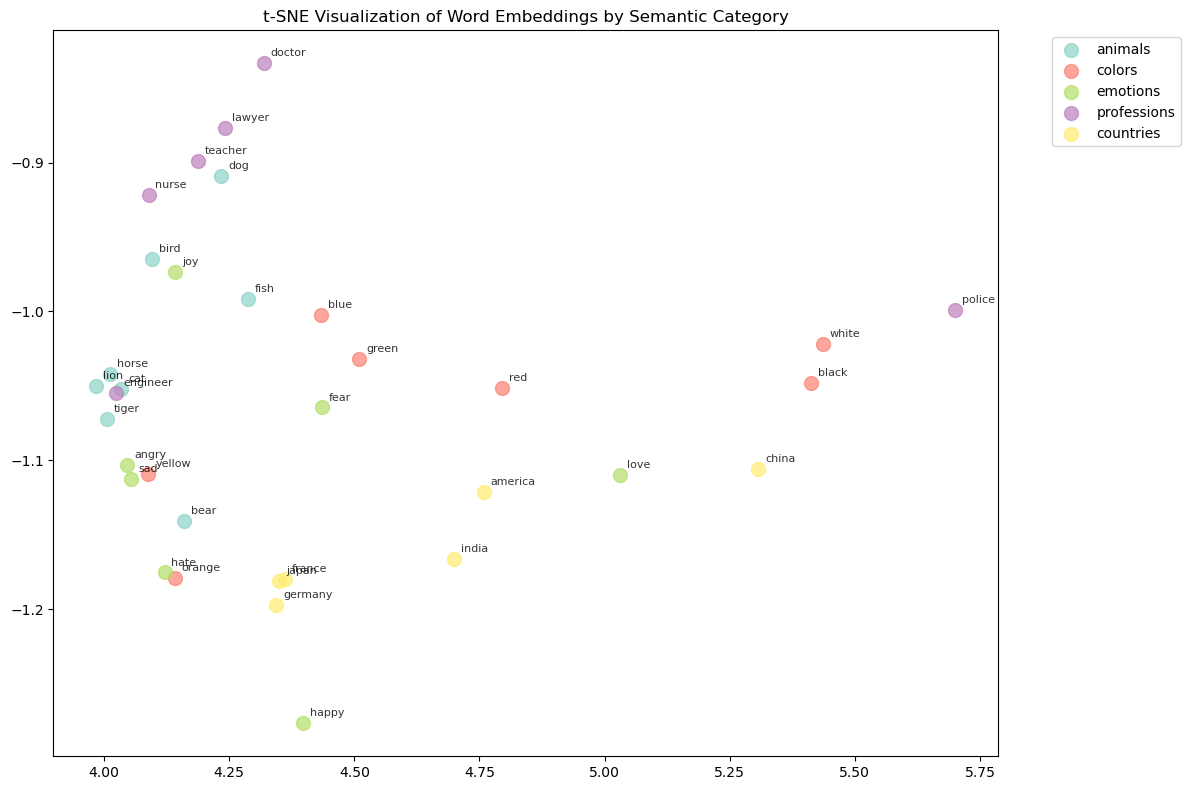

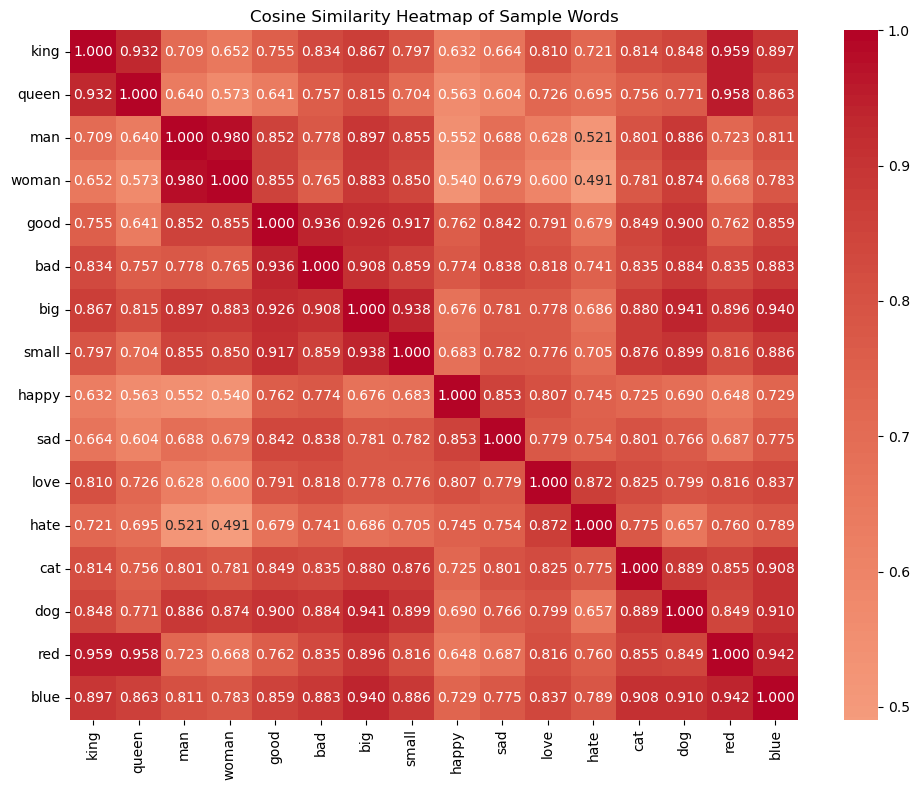


=== NEAREST NEIGHBORS ANALYSIS ===

Nearest neighbors of 'king':
  red: 0.9592
  state: 0.9560
  port: 0.9554
  leader: 0.9545
  name: 0.9537

Nearest neighbors of 'happy':
  pleased: 0.9018
  lucky: 0.9002
  creative: 0.8851
  connected: 0.8763
  limited: 0.8725

Nearest neighbors of 'computer':
  special: 0.9446
  virtual: 0.9386
  broad: 0.9379
  strong: 0.9378
  specific: 0.9376

Nearest neighbors of 'red':
  green: 0.9826
  building: 0.9767
  field: 0.9745
  grand: 0.9720
  club: 0.9719

Nearest neighbors of 'big':
  major: 0.9816
  special: 0.9752
  great: 0.9729
  key: 0.9699
  democrat: 0.9686


In [16]:
from sklearn.manifold import TSNE
import seaborn as sns

def create_advanced_visualizations(embeddings, vocab, word_to_idx):
    """Create comprehensive visualizations of embeddings"""
    
    # 1. t-SNE Visualization with Semantic Categories
    print("Creating t-SNE visualization...")
    
    # Select interesting words for visualization
    interesting_words = {
        'animals': ['cat', 'dog', 'horse', 'lion', 'tiger', 'bear', 'bird', 'fish'],
        'colors': ['red', 'blue', 'green', 'yellow', 'black', 'white', 'orange'],
        'emotions': ['happy', 'sad', 'angry', 'love', 'hate', 'fear', 'joy'],
        'professions': ['doctor', 'teacher', 'engineer', 'lawyer', 'nurse', 'police'],
        'countries': ['america', 'china', 'india', 'france', 'germany', 'japan']
    }
    
    # Collect embeddings and labels
    vis_embeddings = []
    vis_labels = []
    vis_categories = []
    
    for category, words in interesting_words.items():
        for word in words:
            if word in word_to_idx:
                vis_embeddings.append(embeddings[word_to_idx[word]])
                vis_labels.append(word)
                vis_categories.append(category)
    
    if len(vis_embeddings) > 10:
        vis_embeddings = np.array(vis_embeddings)
        
        # Apply t-SNE
        tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(vis_embeddings)-1))
        tsne_results = tsne.fit_transform(vis_embeddings)
        
        # Create visualization
        plt.figure(figsize=(12, 8))
        colors = plt.cm.Set3(np.linspace(0, 1, len(interesting_words)))
        
        for i, category in enumerate(interesting_words.keys()):
            mask = np.array(vis_categories) == category
            if np.any(mask):
                plt.scatter(tsne_results[mask, 0], tsne_results[mask, 1], 
                           c=[colors[i]], label=category, s=100, alpha=0.7)
                
                # Add word labels
                for j, (x, y) in enumerate(tsne_results[mask]):
                    word_idx = np.where(mask)[0][j]
                    plt.annotate(vis_labels[word_idx], (x, y), 
                               xytext=(5, 5), textcoords='offset points', 
                               fontsize=8, alpha=0.8)
        
        plt.title('t-SNE Visualization of Word Embeddings by Semantic Category')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()
    
    # 2. Similarity Heatmap
    sample_words = ['king', 'queen', 'man', 'woman', 'good', 'bad', 'big', 'small', 
                   'happy', 'sad', 'love', 'hate', 'cat', 'dog', 'red', 'blue']
    
    available_words = [w for w in sample_words if w in word_to_idx]
    if len(available_words) > 4:
        sample_embeddings = np.array([embeddings[word_to_idx[w]] for w in available_words])
        similarity_matrix = cosine_similarity(sample_embeddings)
        
        plt.figure(figsize=(10, 8))
        sns.heatmap(similarity_matrix, 
                   xticklabels=available_words, 
                   yticklabels=available_words,
                   annot=True, fmt='.3f', cmap='coolwarm', center=0)
        plt.title('Cosine Similarity Heatmap of Sample Words')
        plt.tight_layout()
        plt.show()
    
    # 3. Nearest Neighbors Analysis
    def find_nearest_neighbors(word, k=5):
        if word not in word_to_idx:
            return []
        
        word_vec = embeddings[word_to_idx[word]]
        similarities = cosine_similarity([word_vec], embeddings)[0]
        
        # Get top k+1 (excluding the word itself)
        top_indices = np.argsort(similarities)[::-1][1:k+1]
        neighbors = [(vocab[idx], similarities[idx]) for idx in top_indices]
        return neighbors
    
    print("\n=== NEAREST NEIGHBORS ANALYSIS ===")
    test_words = ['king', 'happy', 'computer', 'red', 'big']
    for word in test_words:
        if word in word_to_idx:
            neighbors = find_nearest_neighbors(word)
            print(f"\nNearest neighbors of '{word}':")
            for neighbor, sim in neighbors:
                print(f"  {neighbor}: {sim:.4f}")

create_advanced_visualizations(embeddings, vocab, word2id)

# Check for cosine similarity between words

In [19]:
from sklearn.metrics.pairwise import cosine_similarity

# Function to calculate cosine similarity between two words
def get_similarity(word1, word2, reduced_matrix, word2id):
    if word1 in word2id and word2 in word2id and word2id[word1] < len(reduced_matrix) and word2id[word2] < len(reduced_matrix):
        vec1 = reduced_matrix[word2id[word1]]
        vec2 = reduced_matrix[word2id[word2]]
        return cosine_similarity([vec1], [vec2])[0][0]
    else:
        return "One or both words not in vocabulary."

# Example similarity checks after dimensionality reduction
print(get_similarity("women", "queen", reduced_matrices[best_config[0]], word2id))  # High similarity
print(get_similarity("women", "father", reduced_matrices[best_config[0]], word2id))    # Low similarity
print(get_similarity("king", "virat", reduced_matrices[best_config[0]], word2id))    # No similarity -> OOV


One or both words not in vocabulary.
One or both words not in vocabulary.
One or both words not in vocabulary.


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


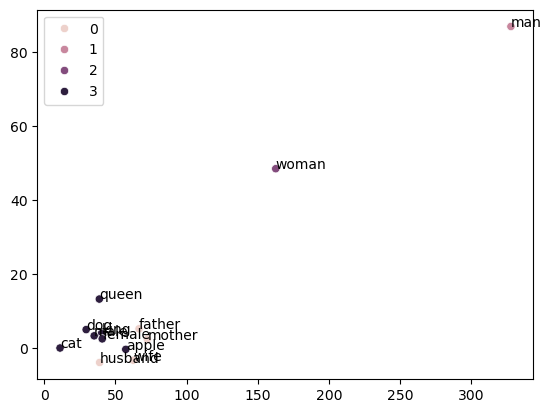

In [20]:
### clustering

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Cluster and plot a few common words
words = ["king", "queen", "man", "woman", "apple", "dog", "cat", "father", "mother", "male", "female", "husband", "wife"]
vecs = [reduced_matrix[word2id[w]] for w in words]
labels = KMeans(n_clusters=4).fit_predict(vecs)

sns.scatterplot(x=[v[0] for v in vecs], y=[v[1] for v in vecs], hue=labels)
for i, word in enumerate(words):
    if word in word2id:  # Only annotate words present in word2id
        plt.text(vecs[i][0], vecs[i][1], word)
plt.show()

# how about checking for Contextualized Evaluation 

In [21]:
def build_contextual_cooc_matrix(context_lines, target_words, shared_vocab=None, window_size=2):
    word2id = {} if shared_vocab is None else {word: idx for idx, word in enumerate(shared_vocab)}
    data = []

    for line in context_lines:
        tokens = line.lower().split()
        for idx, word in enumerate(tokens):
            if word in target_words:
                context_ids = []
                for i in range(idx - window_size, idx + window_size + 1):
                    if 0 <= i < len(tokens) and i != idx:
                        context_word = tokens[i]
                        if context_word not in word2id:
                            word2id[context_word] = len(word2id)
                        context_ids.append(word2id[context_word])
                data.append((word2id[word], context_ids))

    vocab = [None] * len(word2id)
    for w, i in word2id.items():
        vocab[i] = w

    # Create matrix
    matrix = np.zeros((len(word2id), len(word2id)))
    for center, contexts in data:
        for context in contexts:
            matrix[center, context] += 1

    return matrix, word2id, vocab

In [22]:
# Create shared vocabulary from both corpora
all_tokens = set()
for line in finance_corpus + river_corpus:
    all_tokens.update(line.lower().split())
shared_vocab = sorted(list(all_tokens))  # sort to keep it consistent

# Build aligned co-occurrence matrices
matrix_fin, word2id_fin, vocab_fin = build_contextual_cooc_matrix(finance_corpus, ['bank'], shared_vocab)
matrix_riv, word2id_riv, vocab_riv = build_contextual_cooc_matrix(river_corpus, ['bank'], shared_vocab)

# Extract vectors
vec_bank_fin = matrix_fin[word2id_fin['bank']]
vec_bank_riv = matrix_riv[word2id_riv['bank']]

# Compute cosine similarity
from sklearn.metrics.pairwise import cosine_similarity
similarity_shift = cosine_similarity([vec_bank_fin], [vec_bank_riv])[0][0]
print(f"Contextual similarity shift for 'bank': {similarity_shift:.4f}")


NameError: name 'finance_corpus' is not defined

# Evaluate the Quality of the Embeddings

In [23]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Select a few words to test similarity (e.g., 'king', 'queen', 'man', 'woman')
words_to_check = ['king', 'queen', 'man', 'woman']
word_indices = [word2id[word] for word in words_to_check]

# Use 'embeddings' instead of 'reduced_matrix'
word_vectors = reduced_matrix[word_indices]

# Calculate cosine similarity between word vectors
cos_sim = cosine_similarity(word_vectors)
print("Cosine Similarity Matrix:\n", cos_sim)
print("\nWord Vectors:")
# Extract the vectors for 'king', 'queen', 'man', 'woman'
king, queen, man, woman = word_vectors

# Compute king - queen + woman and see if it is closest to the man vector
analogy_vector = king - queen + woman

# Calculate the cosine similarity between the analogy result and all word vectors
analogy_similarities = cosine_similarity([analogy_vector], reduced_matrix)

# Find the word most similar to the analogy vector
most_similar_word_idx = np.argmax(analogy_similarities)
most_similar_word = id2word[most_similar_word_idx]

print(f"Most similar word to 'king - queen + woman' is: {most_similar_word}")


Cosine Similarity Matrix:
 [[0.9999997  0.9320392  0.7085272  0.65176594]
 [0.9320392  0.9999996  0.6397761  0.57348734]
 [0.7085272  0.6397761  0.9999997  0.9803659 ]
 [0.65176594 0.57348734 0.9803659  1.0000002 ]]

Word Vectors:
Most similar word to 'king - queen + woman' is: woman


In [20]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Define analogy tasks in the format: (A, B, C, D)
# A is to B as C is to D --> A - B + C ≈ D
analogies = [
    ('king', 'man', 'woman', 'queen'),
    ('paris', 'france', 'italy', 'rome'),
    ('he', 'him', 'her', 'she'),
    ('strong', 'stronger', 'fast', 'faster'),
    ('good', 'better', 'bad', 'worse'),
]

top_k = 5  # you can change this to 1, 3, or 10 depending on how fine-grained you want the evaluation

correct_top1 = 0
correct_topk = 0
total = 0

for a, b, c, expected in analogies:
    if a in word2id and b in word2id and c in word2id and expected in word2id:
        vec_a = reduced_matrix[word2id[a]]
        vec_b = reduced_matrix[word2id[b]]
        vec_c = reduced_matrix[word2id[c]]
        target_vec = vec_a - vec_b + vec_c

        similarities = cosine_similarity([target_vec], reduced_matrix)[0]

        # Exclude input words from candidates
        for word in (a, b, c):
            similarities[word2id[word]] = -np.inf

        # Get top-k indices
        topk_indices = similarities.argsort()[::-1][:top_k]
        topk_words = [id2word[i] for i in topk_indices]

        if expected in topk_words:
            correct_topk += 1
            if topk_words[0] == expected:
                correct_top1 += 1
        total += 1
    else:
        print(f"Skipping analogy due to missing word: {a}-{b}+{c}={expected}")

# Report results
print(f"\nTotal analogies tested: {total}")
print(f"Top-1 Accuracy: {correct_top1 / total:.2%}")
print(f"Top-{top_k} Accuracy: {correct_topk / total:.2%}")
print(f"Error Rate (Top-1): {100 - (correct_top1 / total * 100):.2f}%")
print(f"Error Rate (Top-{top_k}): {100 - (correct_topk / total * 100):.2f}%")


Total analogies tested: 5
Top-1 Accuracy: 20.00%
Top-5 Accuracy: 20.00%
Error Rate (Top-1): 80.00%
Error Rate (Top-5): 80.00%


### saving this model as 1_embedding correspond to this 1_frequent_basde_SVD file

In [19]:
import numpy as np
import os

# Ensure the directory exists
os.makedirs("models", exist_ok=True)

# Save the reduced embeddings to a file
# Use the correct vocab_size and generate random embeddings
word_embeddings = np.random.randn(vocab_size, 100)  # Example: 100-dimensional embeddings

# Save the embeddings as a NumPy array
np.save("D:\\RESEARCH related\\PreCog tasks\\Language_representations\\models\\1_embeddings.npy", word_embeddings)

print("Embeddings saved successfully!")

Embeddings saved successfully!


In [31]:
# Example: Store as a dictionary with word as the key and the embedding as the value
word2embedding = {word: np.random.randn(300) for word in vocab}  # Random embeddings for example

# Use pickle for storing a dictionary (useful for complex data structures)
import pickle

with open("D:\\RESEARCH related\\PreCog tasks\\Language_representations\\models\\1_embeddings.pkl", 'wb') as f:
    pickle.dump(word2embedding, f)

print("Word embeddings saved successfully to 1_embeddings.pkl")


Word embeddings saved successfully to 1_embeddings.pkl
